In [1]:
"""
https://arxiv.org/pdf/2301.03362
"""

'\nhttps://arxiv.org/pdf/2301.03362\n'

In [2]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from models.unet import BasicUNet
from utils.AddNoise import AddNoiseTransform


device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


In [3]:
# Customowy MNIST z zaszuionymi obrazami
dataset = torchvision.datasets.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        #AddNoiseTransform(noise_level=0.2),  # Add noise to the images
    ])
)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)

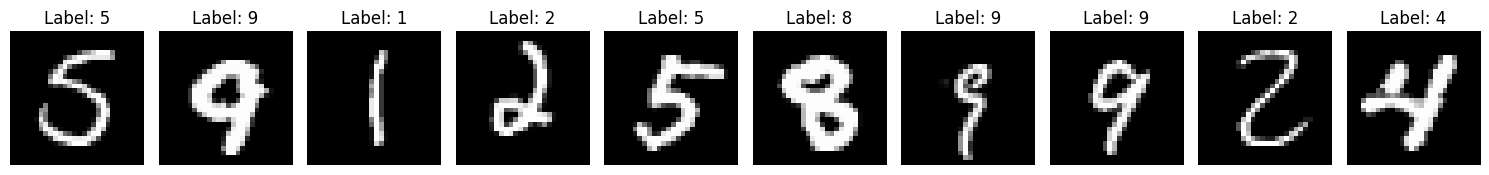

In [4]:
#plot the noisy image
fig, axes = plt.subplots(1, 10, figsize=(15, 5))
for i in range(10):
    img, label = train_set[i]  # Get the image and label
    img = img.squeeze(0).numpy()  # Remove channel dimension and convert to numpy
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

# Odszumianie obrazów

![Unet](./images/noise.jpg)
<br>
### Szum (noise)
Szum to dodatkowe informacje, które nie są związane z obiektem obserwowanym. W przypadku obrazów cyfrowych szum to dodatkowe piksele, które nie są częścią obrazu. Mogą być one spowodowane zakłóceniami wynikającymi z konstukcji urządzenia przechwytującego obraz albo parametrów ekspozycji, wysokie ISO i słabe oświetlenie zazwyczaj prowadzą do zwiększenia szumu. Szum może pojawić się również na skutek obróbki obrazu, kompresji albo upscalingu.
<br>
Obecność szumu powoduje spadek jakości obrazu i oraz utratę zawartych w nim informacji, gdyż oryginalne wartości pixeli są zastępowane przez wartości losowe.

### Rodzaje szumu

### Jak zmierzyć szum?
Najczęściej stosowane są dwie metryki
-   Peak Signal to Noise Ratio (PSNR)
-   Structural Similarity Index (SSIM)

## Gaussian Filter

## Median Filter

## Non Local Means (NLM)

## Autoencoder

## Diffusion

![Unet](./images/unet_diagram.jpg)

In [5]:
def corrupt(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
    return x * (1 - amount) + noise * amount

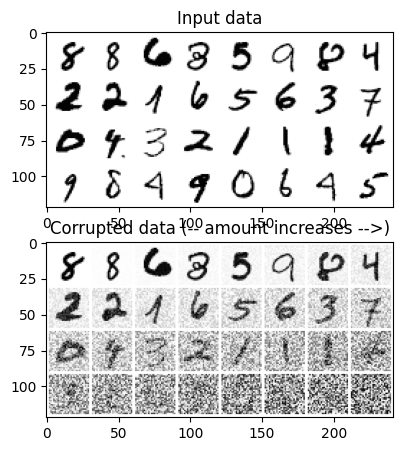

In [6]:
x, y = next(iter(train_dataloader))
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = corrupt(x, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

In [7]:
lr=1e-3
unet = BasicUNet(in_channels=1, out_channels=1).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)
criterion = nn.MSELoss()

In [9]:
# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(10):
    for x, y in train_dataloader:
        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = corrupt(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = unet(noisy_x)

        # Calculate the loss
        loss = criterion(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Epoch {epoch}/10. Average loss: {avg_loss:05f}")

Epoch 0/10. Average loss: 0.013288
Epoch 1/10. Average loss: 0.013164
Epoch 2/10. Average loss: 0.013067
Epoch 3/10. Average loss: 0.012873
Epoch 4/10. Average loss: 0.012753
Epoch 5/10. Average loss: 0.012804
Epoch 6/10. Average loss: 0.012711
Epoch 7/10. Average loss: 0.012680
Epoch 8/10. Average loss: 0.012630
Epoch 9/10. Average loss: 0.012640


### Noise scheduler